In [177]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}, stops tf from complaining about things it shouldn't be worried about
from utils import *
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [196]:
def isCorrect(x, y):
    return (x and y > 0) or (not x and y < 0)

def print_summary(df):
    anomalies = df.loc[df['anomaly'] == -1]
    mistakes = df.loc[df['correct'] == False]
    false_pos = mistakes.loc[mistakes['anomaly'] == -1]
    false_neg = mistakes.loc[mistakes['anomaly'] == 1]

    print(f'False Negative Rate: {false_neg.size/df.size :.5f}\nFalse Positive Rate: {false_pos.size/df.size :.5f}')
    print(f'Accuracy: {100 * (1 - mistakes.size/df.size):.3f}%\n')
    print(f'Pre-Scrub outlier rate: {len(df[df.truth == False])/len(df) :.5f}, {len(df)} Data Points')
    cleaned_df = pd.merge(df, anomalies, indicator=True, how='left').query('_merge=="left_only"').drop('_merge', axis=1)
    print(f'Post-Scrub outlier rate: {len(cleaned_df[cleaned_df.truth == False])/len(cleaned_df) :.5f}, {len(cleaned_df)} Data Points')
    mistakes = cleaned_df.loc[cleaned_df['correct'] == False]
    false_pos = mistakes.loc[mistakes['anomaly'] == -1]
    false_neg = mistakes.loc[mistakes['anomaly'] == 1]
    print(f'Percent of clean data after scrub: {100 * (1 - mistakes.size/cleaned_df.size):.3f}%\n')
    return cleaned_df

def fn_to_df(fn, noise_factor):
    q = np.reshape(fn.y_train, (-1, 1))
    tmp = np.append(fn.x_train, q, axis=1)
    predictors = ['x'+str(i) for i in range(fn.dim)]
    cols = predictors + ['y']
    df = pd.DataFrame(tmp, columns=cols)

    q = np.reshape(fn.y_test, (-1, 1))
    tmp = np.append(fn.x_test, q, axis=1)
    predictors = ['x'+str(i) for i in range(fn.dim)]
    cols = predictors + ['y']
    test_df = pd.DataFrame(tmp, columns=cols)


    mask = np.isclose(fn.y_train, np.array([eval.EvalPt(fn.fn, x)[-1] for x in fn.x_train]), rtol=noise_factor, atol=0.5)
    return df, test_df, mask

# Generate Data

`outlier_rate` controls the percent of data that should be converted to outliers

`noise_factor` controls the magnitude of noise/fuzziness to inject  into the underlying function

Number of bad data points: 89


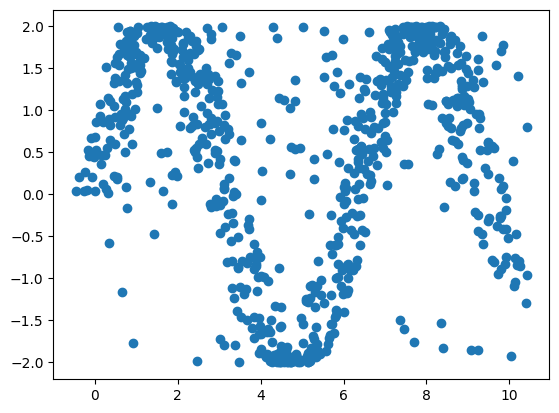

In [213]:
outlier_rate = 0.1
noise_factor = 1
# fn = mystery_function("0>>x{0}*", 1, gen_data=True, noisy=True, noise_factor=noise_factor,sample_size=1_000, scale=10, center=5, outlier_rate=outlier_rate)
fn = mystery_function("0>>x{0}S*", 1, gen_data=True, noisy=True, noise_factor=noise_factor,sample_size=1_000, scale=10, center=5, outlier_rate=outlier_rate)
df, test_df, mask = fn_to_df(fn, noise_factor)
print(f'Number of bad data points: {len(mask)-np.sum(mask)}')
plt.scatter(df["x0"], df["y"])
plt.show()   

# Constructing an outlier detection model
Fit a model to the data above, detect outliers and remove them

<span style="color:#DD0000">Red points</span> are dropped from the original dataset, while <span style="color:cyan">blue points</span> are kept in the dataset

c:\Users\gamer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


False Negative Rate: 0.04500
False Positive Rate: 0.03375
Accuracy: 92.125%

Pre-Scrub outlier rate: 0.11125, 800 Data Points
Post-Scrub outlier rate: 0.05000, 720 Data Points
Percent of clean data after scrub: 95.000%



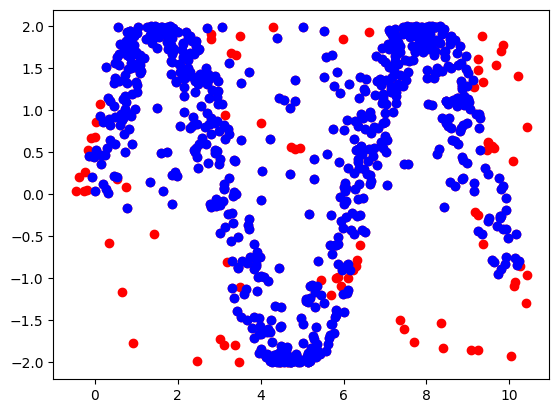

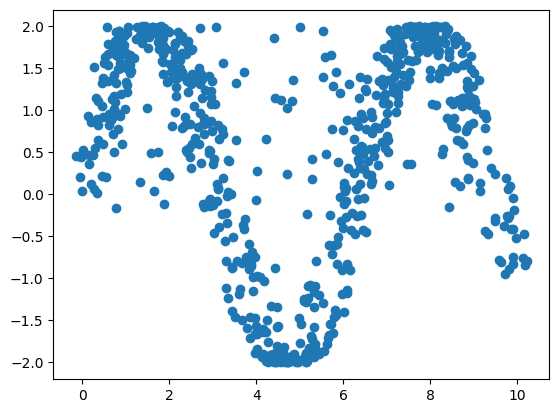

In [222]:
cols = df.columns
#model = IsolationForest(contamination=outlier_rate)
model = IsolationForest()
model.fit(df[cols])

df['anomaly']=model.predict(df[cols])
df['correct']=[True if isCorrect(mask[i], df['anomaly'][i]) else False for i in range(len(mask))]
df['truth']=[x for x in mask]
clean = print_summary(df)

plt.scatter(df['x0'], df['y'], color='red')
plt.scatter(clean["x0"], clean["y"], color='blue')
plt.show()
plt.scatter(clean["x0"], clean["y"])
plt.show()

In [190]:
teacher = getNN(10, 512, fn.shape, name='Dirty')
teacher.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error') # Compile it
teacher.fit(fn.x_train, fn.y_train, epochs=20, verbose=0) # Train
teacher.evaluate(fn.x_test, fn.y_test)


7/7 [==============================] - 0s 7ms/step - loss: 0.4074


0.40737688541412354

Dirty Data
25/25 [==============================] - 0s 8ms/step


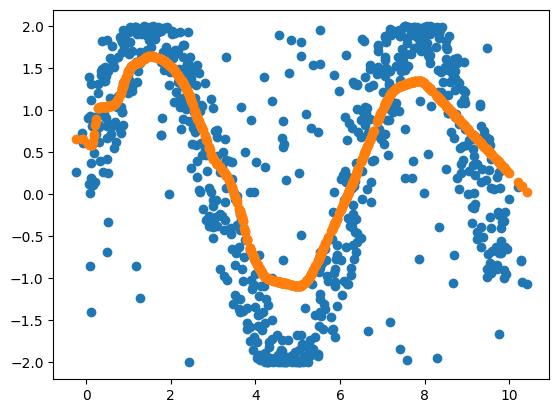

In [182]:

print("Dirty Data")
pred = teacher.predict(fn.x_train)
df["dirty_pred"] = pred
plt.scatter(df["x0"], df["y"])
plt.scatter(df['x0'], df['dirty_pred'])
plt.show()

On test data
7/7 [==============================] - 0s 7ms/step


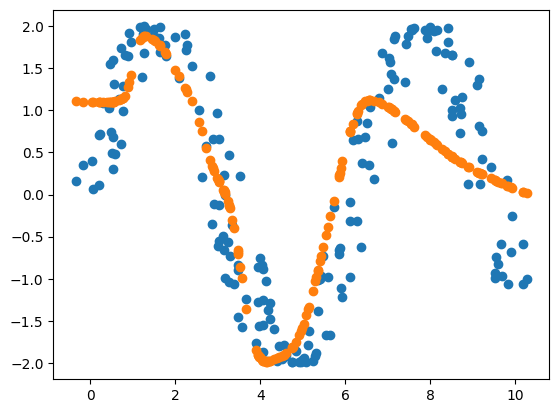

In [193]:
print("On test data")
pred = teacher.predict(fn.x_test)
test_df["test_pred"] = pred
plt.scatter(test_df['x0'], test_df['y'])
plt.scatter(test_df["x0"], test_df["test_pred"])
plt.show()

In [191]:
teacher = getNN(10, 512, fn.shape, name='Clean')
teacher.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error') # Compile it
teacher.fit(clean['x0'], clean['y'], epochs=20, verbose=0) # Train
teacher.evaluate(fn.x_test, fn.y_test)


7/7 [==============================] - 0s 7ms/step - loss: 0.5163


0.5162611603736877

Clean Data
15/15 [==============================] - 0s 7ms/step


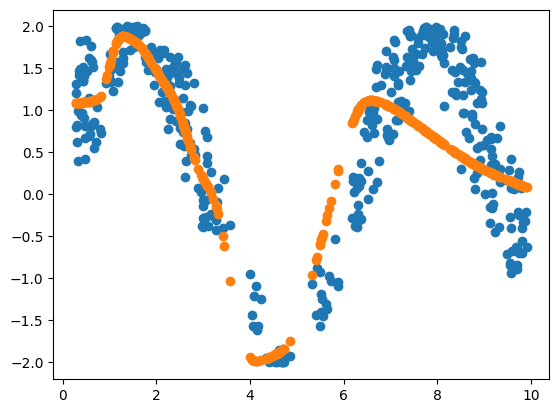

In [194]:
print("Clean Data")
pred = teacher.predict(clean['x0'])
clean["clean_pred"] = pred
plt.scatter(clean["x0"], clean["y"])
plt.scatter(clean['x0'], clean['clean_pred'])
plt.show()

On test data
7/7 [==============================] - 0s 10ms/step


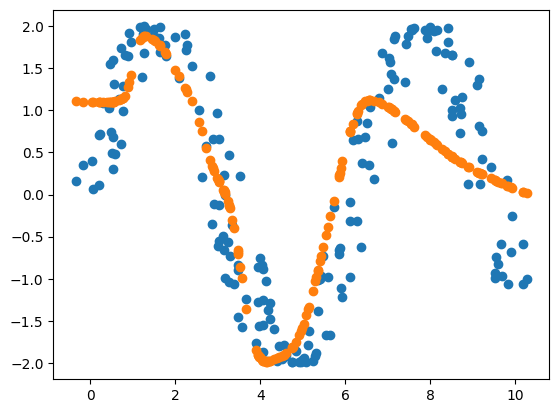

In [195]:
print("On test data")
pred = teacher.predict(fn.x_test)
test_df["test_pred"] = pred
plt.scatter(test_df['x0'], test_df['y'])
plt.scatter(test_df["x0"], test_df["test_pred"])
plt.show()

In [187]:
def main():
    return
    outlier_rate = 0.1
    noise_factor = 0.5
    fn = mystery_function("x{0}S", 1, gen_data=True, noisy=True, noise_factor=noise_factor,sample_size=1_000, scale=10, center=5, outlier_rate=outlier_rate)
    df, test_df, mask = fn_to_df(fn, noise_factor)
    print(f'Number of bad data points: {len(mask)-np.sum(mask)}')

    cols = df.columns
    model = IsolationForest()
    model.fit(df[cols])

    df['anomaly']=model.predict(df[cols])
    df['correct']=[True if isCorrect(mask[i], df['anomaly'][i]) else False for i in range(len(mask))]
    df['truth']=[x for x in mask]
    plt.scatter(df["x0"], df["y"])
    plt.show()    
    # plt.savefig(f"./{FIG_DIR}/pre.png")
    clean = print_summary(df)
    plt.scatter(clean["x0"], clean["y"])
    plt.show()
    # plt.savefig(f"./{FIG_DIR}/clean.png")

    teacher = getNN(10, 256, fn.shape, name='Dirty')
    
    teacher.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error') # Compile it
    teacher.fit(fn.x_train, fn.y_train, epochs=20) # Train
    teacher.evaluate(fn.x_test, fn.y_test)
    plt.scatter(df["x0"], df["y"])
    pred = teacher.predict(fn.x_train)
    df["dirty_pred"] = pred
    print("Dirty Data")
    plt.scatter(df["x0"], df["y"])
    print("What the teacher learned")
    plt.scatter(df['x0'], df['dirty_pred'])
    plt.show()
    pred = teacher.predict(fn.x_test)
    test_df["test_pred"] = pred
    print("On test data")
    plt.scatter(test_df['x0'], test_df['y'])
    plt.scatter(test_df["x0"], test_df["test_pred"])
    plt.show()    

    teacher = getNN(10, 256, fn.shape, name='Clean')
    teacher.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error') # Compile it
    teacher.fit(clean['x0'], clean['y'], epochs=20) # Train
    teacher.evaluate(fn.x_test, fn.y_test)
    pred = teacher.predict(clean['x0'])
    clean["clean_pred"] = pred
    plt.scatter(clean["x0"], clean["y"])
    plt.scatter(clean['x0'], clean['clean_pred'])
    plt.show()
    pred = teacher.predict(fn.x_test)
    test_df["test_pred"] = pred
    print("On test data")
    plt.scatter(test_df['x0'], test_df['y'])
    plt.scatter(test_df["x0"], test_df["test_pred"])
    plt.show()
    return

    fn = mystery_function("x{0}S", 1, gen_data=True, sample_size=1_000, scale=10, center=5, outlier_rate=2*outlier_rate)
    df, mask = fn_to_df(fn, noise_factor)

    df['anomaly']=model.predict(df[cols])
    df['correct']=[True if isCorrect(mask[i], df['anomaly'][i]) else False for i in range(len(mask))]
    df['truth']=[x for x in mask]
    plt.scatter(df["x0"], df["y"])
    plt.show()    
    # plt.savefig(f"./{FIG_DIR}/pre.png")
    clean = print_summary(df)

    plt.scatter(clean["x0"], clean["y"])
    plt.show()
    # plt.savefig(f"./{FIG_DIR}/clean.png")

if __name__ == "__main__":
    main()